In [ ]:
import tensorflow as tf
from keras.layers import Input, Dense, MaxPool2D, Conv2D, AveragePooling2D, Flatten
from keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from keras import backend as K

import os
import numpy as np
import cv2
import random
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# I. Path file

In [ ]:
path_project = '/content/gdrive/MyDrive/Classroom/Computer_vision'
path_data = '/content/gdrive/MyDrive/Data'
path_train = os.path.join(path_data, 'dog2/128_128/Train.npz')
path_test = os.path.join(path_data, 'dog2/128_128/Test.npz')

# II. Load data

In [ ]:
def load(train_path, test_path):
  Train = np.load(train_path)
  Test = np.load(test_path)
  return Train, Test

In [ ]:
Train, Test = load(path_train, path_test)
X_train, y_train = Train['X'], Train['y']
X_test, y_test = Test['X'], Test['y']

# y_train = y_train.astype(np.float32)
# y_test = y_test.astype(np.float32)

# III. Build Model

In [ ]:
def build_model(IMG_WIDTH=128, IMG_HEIGHT=128, IMG_CHANNELS=3):
  #Build the model
  inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

  #Contraction path
  c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
  c1 = tf.keras.layers.Dropout(0.1)(c1)
  c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = tf.keras.layers.Dropout(0.1)(c2)
  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
  
  c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = tf.keras.layers.Dropout(0.2)(c3)
  c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
  
  c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = tf.keras.layers.Dropout(0.2)(c4)
  c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
  
  c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = tf.keras.layers.Dropout(0.3)(c5)
  c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  #Expansive path 
  u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = tf.keras.layers.Dropout(0.2)(c6)
  c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
  
  u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = tf.keras.layers.Dropout(0.2)(c7)
  c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
  
  u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = tf.keras.layers.Dropout(0.1)(c8)
  c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
  
  u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = tf.keras.layers.Dropout(0.1)(c9)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
  
  outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  #model.compile(optimizer='adam', loss=[jacard_coef_loss], metrics=[jacard_coef])

  model.summary()

  return model

In [ ]:
model = build_model()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_2 (Lambda)              (None, 128, 128, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 16  448         ['lambda_2[0][0]']               
                                )                                                                 
                                                                                            

In [ ]:
################################
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks= callbacks)

####################################

Epoch 1/50
203/203 [==============================] - 30s 133ms/step - loss: 0.3593 - accuracy: 0.8770 - val_loss: 0.3282 - val_accuracy: 0.8792
Epoch 2/50
203/203 [==============================] - 27s 131ms/step - loss: 0.3119 - accuracy: 0.8854 - val_loss: 0.3154 - val_accuracy: 0.8792
Epoch 3/50
203/203 [==============================] - 26s 129ms/step - loss: 0.3063 - accuracy: 0.8854 - val_loss: 0.3113 - val_accuracy: 0.8792
Epoch 4/50
203/203 [==============================] - 27s 131ms/step - loss: 0.2941 - accuracy: 0.8854 - val_loss: 0.3128 - val_accuracy: 0.8792
Epoch 5/50
203/203 [==============================] - 27s 131ms/step - loss: 0.2823 - accuracy: 0.8853 - val_loss: 0.2831 - val_accuracy: 0.8792
Epoch 6/50
203/203 [==============================] - 27s 131ms/step - loss: 0.2649 - accuracy: 0.8903 - val_loss: 0.2568 - val_accuracy: 0.8934
Epoch 7/50
203/203 [==============================] - 27s 131ms/step - loss: 0.2490 - accuracy: 0.8960 - val_loss: 0.2756 - val_ac

# IV. Load model

In [ ]:
model = load_model("/content/gdrive/MyDrive/Data/dog2/128_128/dog.h5")

In [ ]:
preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

13/13 [==============================] - 1s 57ms/step


########################################################333


In [ ]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

In [ ]:
def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

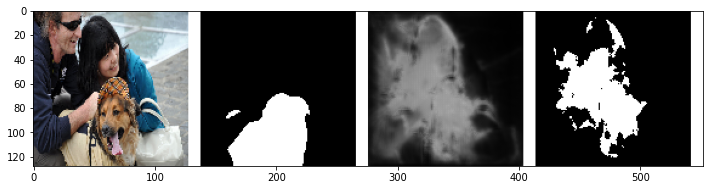

In [ ]:
ix = random.randint(0, len(preds_test_t))
h, w, _ = X_test[ix].shape
white_line = np.ones((h, 10, 3))

all_images = [
              cv2.cvtColor((X_test[ix]/255.0).astype(np.float32), cv2.COLOR_BGR2RGB), white_line,
              mask_parse(y_test[ix]), white_line,
              mask_parse(preds_test[ix]), white_line,
              mask_parse(preds_test_t[ix]).astype(np.float32), white_line
              ]

image = np.concatenate(all_images, axis=1)
fig = plt.figure(figsize=(12, 12))
a = fig.add_subplot(1, 1, 1)
imgplot = plt.imshow(image)

In [ ]:
##################################################

In [ ]:
def IoU(y_true, y_pred):
  intersection = np.logical_and(y_true, y_pred)
  union = np.logical_or(y_true, y_pred)
  iou_score = np.sum(intersection) / np.sum(union)
  return iou_score

In [ ]:
acc= []
for y_true, y_pred in zip(y_test, preds_test_t):
  score = IoU(y_true, y_pred)
  acc.append(score)
print('score: ', np.mean(acc))

score:  0.2478762303021343


# V. Demo

In [ ]:
def read_image(path, IMAGE_SIZE=128):
    x = cv2.imread(path)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    return x

In [ ]:
path = '/content/gdrive/MyDrive/Data/dog2/Demo/000000008458.jpg'
img = read_image(path)

In [ ]:
preds_test = model.predict(np.expand_dims(img, axis=0), verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 29ms/step


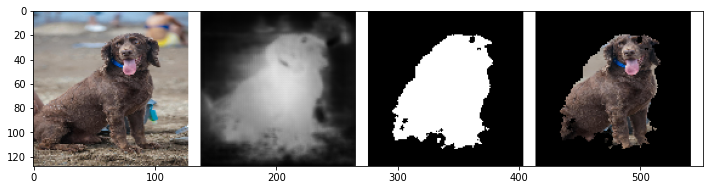

In [ ]:
white_line = np.ones((128, 10, 3))

img_ = cv2.cvtColor((img/255.0).astype(np.float32), cv2.COLOR_BGR2RGB)
mask_pred = mask_parse(preds_test[0])
mask_pred_t = mask_parse(preds_test_t[0]).astype(np.float32)

mask1 = np.squeeze(preds_test_t[0])
imgResult = cv2.bitwise_and(img, img, mask=mask1)
imgResult = cv2.cvtColor((imgResult/255.0).astype(np.float32), cv2.COLOR_BGR2RGB)

all_images = [
              img_, white_line,
              mask_pred, white_line,
              mask_pred_t, white_line,
              imgResult, white_line
              ]

image = np.concatenate(all_images, axis=1)
fig = plt.figure(figsize=(12, 12))
a = fig.add_subplot(1, 1, 1)
imgplot = plt.imshow(image)